# Variational Quantum Eigensolver with Estimator Primitive

## Overview

The Variational Quantum Eigensolver (VQE) is an optimization routine for finding the ground state energy (i.e. lowest eigenvalue) of a Hamiltonain and is a considered to be a viable candidate for NISQ hardware. In this tutorial, we will go over how to use IBM Quantum Runtime to submit your VQE's to the cloud. Specifically, we will be looking at calculating the ground state energy of the $H_2$ molecule using the estimator primitive. 

### Create Service
First we have to create our service instance and instantiate our estimator factory. In this example we will be working with a simulator for the sake of speed, but by simply changing this one line (for choice of backend) this could run on hardware as well. 

In [1]:
from qiskit_ibm_runtime import IBMRuntimeService, IBMEstimator

service = IBMRuntimeService()

estimator_factory = IBMEstimator(service=service, backend="ibmq_qasm_simulator")

### Molecular Hamiltonians

We will be working with Qiskit Nature to generate and handle molecular hamiltonians. First though, we need to install these packages. 

In [ ]:
pip install qiskit-nature
pip install 'qiskit-nature[pyscf]'


Now we need to generate the Hamiltonians that we wish to find the ground state energy of. For this task we will be utilizing qiskit nature. First we have to specify how we are converting the fermionic operators of the electronic molecular hamiltonian to qubit operators. Here we will use the Parity Mapper, which maps annihilation to Pauli operators via $ \hat{a} \rightarrow \frac{1}{2} \left ( X_p Z_{p-1} + i Y_p \right ) X_{p+1} ... X_{N} $

In [2]:
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper

qubit_converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)

At our specified bond length we will create an electronic structure problem and generate the second quantized (i.e. fermionic) operators. We then compute the true ground state energy to compare against. 

In [3]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms import MinimumEigensolverResult
from qiskit.opflow import TaperedPauliSumOp
import numpy as np

dist = 0.72

ops = []

molecule = Molecule(geometry=[['H', [0., 0., 0.]], ['H', [0., 0., dist]]])
driver = ElectronicStructureMoleculeDriver(molecule, basis='sto3g', \
                                           driver_type=ElectronicStructureDriverType.PYSCF)

es_problem = ElectronicStructureProblem(driver)
second_q_ops = es_problem.second_q_ops()      
hamiltonian = qubit_converter.convert(second_q_ops[0], num_particles=es_problem.num_particles)
sol = MinimumEigensolverResult()
sol.eigenvalue = NumPyMinimumEigensolver().compute_minimum_eigenvalue(hamiltonian).eigenvalue
real_solution = es_problem.interpret(sol).total_energies[0]

h = hamiltonian.primitive
h.coeffs = np.real(hamiltonian.coeffs)
ops.append(TaperedPauliSumOp(h, hamiltonian.z2_symmetries))

Now we can use this hamiltonian as the observable in our estimator factory. The VQE routine is formalized as $\min_\theta \langle \Psi | \hat{H} | \Psi \rangle $, so we just need to minimize the expectation values of the hamiltonian. 

In [4]:
from qiskit.algorithms.optimizers import NELDER_MEAD
from qiskit.circuit.library import RealAmplitudes

circuit = RealAmplitudes(num_qubits=2, reps=2).decompose()
convergence = []

with estimator_factory(
    circuits=[circuit],
    observables=ops,
) as estimator:
    def evaluate_expectation(x):
        x = list(x)
        results = estimator(circuit_indices=[0], observable_indices=[0], parameter_values=[x]).values[0]
        return np.real(results)
    
    def callback(fx):
        convergence.append(evaluate_expectation(fx))

    np.random.seed(1)
    initial_point = np.random.uniform(-np.pi, np.pi, len(circuit.parameters))
    spsa = NELDER_MEAD(80, callback=callback)
    _, vqe_solution, _ = spsa.optimize(initial_point.size, evaluate_expectation, initial_point=initial_point) 

    sol = MinimumEigensolverResult()
    sol.eigenvalue = vqe_solution
    vqe_sol = es_problem.interpret(sol).total_energies[0]


Now that we solved the electronic hamiltonian, we have to add the nuclear energies.

In [5]:
vqe_interpret = []
for i in range(len(convergence)):
    sol = MinimumEigensolverResult()
    sol.eigenvalue = convergence[i]
    sol = es_problem.interpret(sol).total_energies[0]
    vqe_interpret.append(sol)

Finally, we can see our convergence plot!

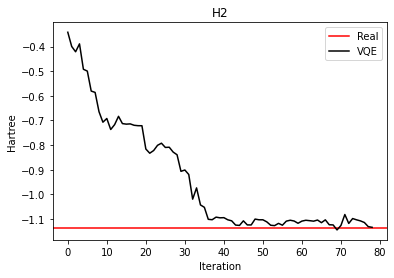

In [6]:
import matplotlib.pyplot as plt

plt.axhline(real_solution, label='Real', color='red')
plt.plot(vqe_interpret, label='VQE', color='black')
plt.title("H2")
plt.xlabel('Iteration')
plt.ylabel('Hartree')
plt.legend()
plt.show()

In [7]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.19.2', 'qiskit-aer': '0.10.3', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.18.3', 'qiskit-aqua': '0.9.5', 'qiskit': '0.34.2', 'qiskit-nature': '0.3.1', 'qiskit-finance': None, 'qiskit-optimization': '0.3.1', 'qiskit-machine-learning': '0.2.1'}